In [1]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import math

import pyarrow.parquet as pq
import pyarrow as pa
from io import BytesIO
import boto3

In [2]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout, Reshape, Conv1D, Masking, LSTM, Conv2D, Input, Multiply, Lambda
from keras.optimizers import Adam
from keras.regularizers import L2, L1L2, L1
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping

In [3]:
# CARGAMOS LOS RETORNOS DE TODOS LOS ACTIVOS QUE HAN PERTENECIDO AL IBEX35 Y EL BENCHMARK
returns = pd.read_csv('ibex_historical_returns.csv',index_col='date')
returns.index = pd.to_datetime(returns.index)
returns.head()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-17,NaN,NaN,NaN,NaN,NaN,0.000831,NaN,NaN,NaN,0.023395,...,NaN,NaN,NaN,NaN,0.025183,NaN,NaN,NaN,NaN,0.016909
1993-08-18,NaN,NaN,NaN,NaN,NaN,-0.002079,NaN,NaN,NaN,0.003814,...,NaN,NaN,NaN,NaN,0.027093,NaN,NaN,NaN,NaN,0.012458
1993-08-19,NaN,NaN,NaN,NaN,NaN,-0.004088,NaN,NaN,NaN,-0.009661,...,NaN,NaN,NaN,NaN,-0.021590,NaN,NaN,NaN,NaN,0.007611
1993-08-20,NaN,NaN,NaN,NaN,NaN,-0.007048,NaN,NaN,NaN,-0.005882,...,NaN,NaN,NaN,NaN,-0.005504,NaN,NaN,NaN,NaN,-0.000402
1993-08-23,NaN,NaN,NaN,NaN,NaN,-0.002867,NaN,NaN,NaN,-0.027700,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,-0.003132


In [4]:
# CARGAMOS LOS DATOS DE PRECIOS DE CIERRE AJUSTADO PARA TODOS LOS ACTIVOS QUE HAN PERTENECIDO AL IBEX35 Y EL BENCHMARK
prices = pd.read_csv('ibex_historical_data.csv', index_col='date')
prices.index = pd.to_datetime(prices.index)
prices.head()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-16,NaN,NaN,NaN,NaN,NaN,1.2025,NaN,NaN,NaN,3.4515,...,NaN,NaN,NaN,NaN,2.9683,NaN,NaN,NaN,NaN,3113.896729
1993-08-17,NaN,NaN,NaN,NaN,NaN,1.2035,NaN,NaN,NaN,3.5332,...,NaN,NaN,NaN,NaN,3.0440,NaN,NaN,NaN,NaN,3166.996826
1993-08-18,NaN,NaN,NaN,NaN,NaN,1.2010,NaN,NaN,NaN,3.5467,...,NaN,NaN,NaN,NaN,3.1276,NaN,NaN,NaN,NaN,3206.696777
1993-08-19,NaN,NaN,NaN,NaN,NaN,1.1961,NaN,NaN,NaN,3.5126,...,NaN,NaN,NaN,NaN,3.0608,NaN,NaN,NaN,NaN,3231.196777
1993-08-20,NaN,NaN,NaN,NaN,NaN,1.1877,NaN,NaN,NaN,3.4920,...,NaN,NaN,NaN,NaN,3.0440,NaN,NaN,NaN,NaN,3229.896729


In [5]:
# CARGAMOS LOS DATOS DE LA TASA DE RETORNO DE LOS BONOS A 3 MESES DE LOS EEUU
t_bill_files = [filename for filename in os.listdir('./Datos TFM') if filename.startswith("United States 3-Month Bond Yield")]
t_bill_data = pd.DataFrame()
for f in t_bill_files:
    file_path = './Datos TFM/'+f
    file = pd.read_csv(file_path)
    t_bill_data = pd.concat([t_bill_data,file],axis=0)
t_bill_data.index = pd.to_datetime(t_bill_data.Date)
t_bill_data.drop('Date',axis=1,inplace=True)
t_bill_data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2023-07-25,5.436,5.432,5.439,5.426,0.34%
2023-07-24,5.418,5.453,5.486,5.418,-0.11%
2023-07-21,5.424,5.445,5.469,5.411,0.15%
2023-07-20,5.416,5.448,5.503,5.409,0.07%
2023-07-19,5.412,5.452,5.452,5.409,0.00%


In [6]:
def locate_in_df(df, value):
    a = df.to_numpy()
    row = np.where(a == value)[0][0]
    col = np.where(a == value)[1][0]
    return row, col
locate_in_df(returns,returns.min().min()), returns.min().min()

((5135, 36), -1.0195842263237869)

In [7]:
# ELIMINAMOS OUTLIERS EN LOS PRECIOS Y RETORNOS
prices.iloc[5136:,36] = np.nan
returns.iloc[5135:,36] = np.nan
prices.iloc[5626:, 2] = np.nan
returns.iloc[5625:, 2] = np.nan

In [8]:
# DEFINIMOS NUESTRA TASA LIBRE DE RIESGO A TRAVÉS DE LOS VALORES DE LA TASA T-BILLS DE 3 MESES
risk_free_rate = t_bill_data['Price']/100
risk_free_rate = risk_free_rate.sort_index()
returns['risk_free_rate'] = risk_free_rate.loc[returns.index[0]:]
returns['risk_free_rate'] = returns['risk_free_rate'].fillna(method='ffill')

NECESITAMOS ARMAR UN DATASET CON INFORMACIÓN SOBRE CADA ACCIÓN CADA DIA. NUESTRO PROBLEMA NO SE BASA EN PREDECIR UN SERIE HISTÓRICA, SINO EN CLASIFICAR UN ACTIVO DEPENDIENDO DE SI EN EL ULTIMO PERÍODO ANALIZADO SE ENCUENTRA DENTRO DEL TOP 10 DE ACTIVOS BAJO UN CRITERIO O NO.

PARA ESTO ARMAREMOS UN DATASET PERO SIN IMPORTAR CUAL ES LA POSICIÓN DE CADA ACCIÓN EN SÍ DENTRO DEL RANKING. LO QUE NOS INTERESA SON LOS SIGUIENTES DATOS:
1) MEDIA DE RETORNOS DEL ULTIMO PERIODO A ANALIZAR                          OK
2) SHARPE DEL ULTIMO PERIODO A ANALIZAR                                     OK
3) CANTIDAD DE DIAS EN EL INDICE                                            OK
4) ALFA DE JENSEN DEL ULTIMO PERIODO A ANALIZAR                             OK
5) BETA DEL ULTIMO PERIODO A ANALIZAR                                       OK
6) DESVIACIÓN ESTANDARD DEL ULTIMO PERIODO A ANALIZAR                       OK
7) CANTIDAD DE DIAS EN EL TOP 10
8) MAXIMO DRAWDOWN DEL ULTIMO PERIODO A ANALIZAR                            COMO NO TENEMOS TODO EL HISTORICO DE DATOS DE TODOS LOS ACTIVOS NO ES CONVENIENTE CALCULAR ESTA
                                                                            MEDIDA
9) RATIO DE TREYNOR DEL ULTIMO PERIODO A ANALIZAR                           OK
10) MEDIDA DE MODIGLIANI DEL ULTIMO PERIODO A ANALIZAR                      OK
11) RATIO DE SORTINO DEL ULTIMO PERIODO A ANALIZAR                          OK
12) DISTANCIA CON RESPECTO AL BENCHMARK EN RATIO DE SHARPE                  OK
13) RATIO DE CALMAR DEL ULTIMO PERIODO A ANALIZAR                           COMO NO TENEMOS TODO EL HISTORICO DE DATOS DE TODOS LOS ACTIVOS NO ES CONVENIENTE CALCULAR ESTA
                                                                            MEDIDA
14) MINIMO RETORNO DEL ULTIMO PERIODO A ANALIZAR                            OK
15) MAXIMO RETORNO DEL ULTIMO PERIODO A ANALIZAR                            OK
16) RETORNO ACUMULADO DEL ULTIMO PERIODO A ANALIZAR                         OK
17) RETORNO TOTAL DEL ULTIMO PERIODO A ANALIZAR                             OK
18) RETORNO TOTAL DESDE INGRESO AL INDICE                                   OK
19) MAXIMO DESDE INGRESO AL INDICE                                          OK
20) MINIMO DESDE INGRESO AL INDICE                                          OK
21) DIAS DESDE ULTIMO MAXIMO                                                
22) DIAS DESDE ULTIMO MINIMO
23)                          

NUESTRA ETIQUETA A PREDECIR ES SI EL ACTIVO SE ENCUENTRA O NO EN EL TOP 10 DE ACTIVOS DEL INDICE. NUESTRO OBJETIVO NO ES PUNTUAR A LOS ACTIVOS DADO QUE LUEGO REALIZAREMOS LA ASIGNACIÓN DE PESOS A TRAVÉS DE MARKOWITZ. NUESTRO OBJETIVO ES SELECCIONAR ACTIVOS DEL TOTAL DE ACTIVOS QUE SE ENCUENTRAN EN EL INDICE:
- 0: NO SE ENCUENTRA EN EL TOP 10.
- 1: SE ENCUENTRA EN EL TOP 10.

DEBEMOS ITERAR PARA TODOS LOS ACTIVOS Y PARA TODOS LOS DIAS COMPLETANDO LA INFORMACIÓN DE NUESTRO DATASET. AL FINAL TENDREMOS UN DATASET CON N + 1 COLUMNAS (SIENDO N LA CANTIDAD DE FEATURES QUE TENEMOS EN NUESTRO DATASET) Y SUMANDO LA ETIQUETA 0 O 1 DEPENDIENDO DE SI ESTUVO EN EL INDICE EN ESE DIA O NO. NUESTRO DATASET FINAL TENDRÁ M FILAS SIENDO M LA CANTIDAD DE DIAS QUE HA COTIZADO CADA ACTIVO RESTANDO LA CANTIDAD DE PERIODOS QUE SE TOMEN PARA HACER EL PRIMER ANALISIS MULTIPLICADO POR LA CANTIDAD DE ACTIVOS. PARA LA ENTRADA A LA RED NO ES NECESARIO CONOCER QUÉ ACCIÓN ESTAMOS SELECCIONANDO DADO QUE LO QUE NOS IMPORTAN SON SUS CARACTERISTICAS EN EL DIA ANALIZADO. LO QUE SE BUSCA ES ENTONCES DADA UNA SERIE DE CARACTERISTICAS, ETIQUETAR UNA ACCIÓN. LUEGO SE TOMARÁN LOS RECAUDOS NECESARIOS PARA ENTENDER QUÉ ACCIÓN ES Y EN QUÉ MOMENTO. NUESTRO ANALISIS BUSCA TOMAR UNA DECISIÓN A DIA DE HOY BASANDONOS EN INFORMACIÓN HISTÓRICA. NO BUSCA PREDECIR LA BOLSA NI ANALIZAR QUE PASARÁ DE AQUI EN EL FUTURO.

In [114]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import pandas as pd

In [115]:
def getIVP(cov,**kargs): 
    # Compute the inverse-variance portfolio 
    ivp=1./np.diag(cov)
    ivp/=ivp.sum() 
    return ivp 
#------------------------------------------------------------------------------ 
def getClusterVar(cov,cItems): 
    # Compute variance per cluster 
    cov_=cov.loc[cItems,cItems]
    # matrix slice 
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar 
#------------------------------------------------------------------------------
def getQuasiDiag(link): 
    # Sort clustered items by distance 
    link=link.astype(int) 
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] 
    # number of original items 
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1 
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2 
        sortIx=sortIx.sort_index() # re-sort
        sortIx.index=range(sortIx.shape[0])
        # re-index 
        
    return sortIx.tolist()
    
def getRecBipart(cov,sortIx):
    # Compute HRP alloc 
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster 
    while len(cItems)>0: 
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)//2),(len(i)//2,len(i))) if len(i)>1] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0=cItems[i] # cluster 1 
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0) 
            cVar1=getClusterVar(cov,cItems1) 
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1 
            w[cItems1]*=1-alpha # weight 2 
    return w

def correlDist(corr): # A distance matrix based on correlation, where 0<=d[i,j]<=1 # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist 

def hierarchical_risk_parity(data,last_date,alpha,corr,cov):
    activos = data.dropna().index[:-1]
    alpha_activos = alpha.loc[last_date,activos].sort_values(ascending=False)
    selected_assets = alpha_activos[alpha_activos>0].index
    corr = corr.loc[last_date][selected_assets].T[selected_assets]
    cov = cov.loc[last_date][selected_assets].T[selected_assets]
    dist = correlDist(corr) 
    link = sch.linkage(dist.dropna(),'single') 
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist() # recover labels 
    df0 = corr.loc[sortIx,sortIx] # reorder 
    hrp = getRecBipart(cov,sortIx) 
    return hrp

ValueError: shapes (1,10) and (99,99) not aligned: 10 (dim 1) != 99 (dim 0)

In [117]:
# REALIZAMOS LA GENERACIÓN DE CARACTERISTICAS PARA UNA SOLA ACCIÓN PARA UN SOLO DÍA. ASÍ COMO TAMBIEN TRAERSE LOS DATOS DEL BENCHMARK Y LA TASA LIBRE DE RIESGO
# PRIMERO TOMAMOS LOS RETORNOS DIARIOS AL CIERRE DEL PRIMER PERIODO A SELECCIONAR. TOMAMOS COMO PERIODO 30 DÍAS.
DIAS = 30
VAR_LIMIT = 0.05

In [248]:
dataset = pd.DataFrame()

for c in range(0, returns.shape[1] - 2):

    period_data = returns.iloc[:,[c,-2,-1]].dropna()
    stock_prices = prices.iloc[1:,c].dropna()
    returns_act = period_data.iloc[:,0]
    returns_risk_free_rate = period_data.iloc[:,-1]
    returns_benchmark = period_data.iloc[:,-2]

    for i in range(period_data.shape[0] - DIAS):
        # OBTENEMOS EL NOMBRE DEL ACTIVO
        stock_name = returns_act.name
        
        # OBTENEMOS LOS RETORNOS DEL PERIODO ANTERIOR
        previous_period_act = returns_act[i:DIAS+i]

        # CALCULAMOS LOS RETORNOS TOTALES, RETORNOS ACUMULADOS, RETORNOS DESDE SU ENTRADA AL INDICE
        previous_period_total_returns = returns_act[DIAS+i] - returns_act[i]
        previous_period_cumulative_returns = returns_act[i:DIAS+i].sum()
        total_act_cumulative_returns = returns_act[:DIAS+i].sum()
        # CALCULAMOS LA MEDIA Y LA DESVIACIÓN ESTANDARD DE ESE PERIODO
        previous_period_mean_returns = previous_period_act.mean()
        previous_period_std_returns = previous_period_act.std()

        # CALCULAMOS LOS RETORNOS MAXIMOS Y MINIMOS DEL PERIODO
        previous_period_max_returns = previous_period_act.max()
        previous_period_min_returns = previous_period_act.min()

        # OBTENEMOS LOS DIAS QUE ESTUVO EN EL INDICE HASTA EL MOMENTO
        days_in_index = DIAS + i

        # OBTENEMOS EL DIA DE ANALISIS
        date = previous_period_act.index[-1]
        
        # CALCULAMOS EL MAXIMO Y EL MINIMO DESDE LA SALIDA AL INDICE
        total_act_max_price = stock_prices[:DIAS+i].max()
        total_act_min_price = stock_prices[:DIAS+i].min()

        days_since_last_max = (stock_prices.index[DIAS+i] - stock_prices[:DIAS+i].loc[stock_prices==total_act_max_price].index).days.values[0]
        days_since_last_min = (stock_prices.index[DIAS+i] - stock_prices[:DIAS+i].loc[stock_prices==total_act_min_price].index).days.values[0]

        daily_drawdown = (stock_prices[:DIAS+i] / total_act_max_price) - 1
        max_drawdown = daily_drawdown.min()

        # PARA CALCULAR EL RATIO DE SHARPE DEBEMOS OBTENER LOS DATOS DE LA TASA LIBRE DE RIESGO PARA ESE DIA Y DIVIDIR EL RETORNO MEDIO AJUSTADO POR LA TASA LIBRE DE RIESGO
        # POR LA DESVIACIÓN ESTANDAR DE LOS RETORNOS.
        period_risk_free_rate = returns_risk_free_rate.iloc[DIAS+i]

        # CALCULAMOS EL RATIO DE SHARPE PARA ESTE PERIODO
        period_sharpe_ratio = (previous_period_mean_returns - period_risk_free_rate) / previous_period_std_returns

        # CALCULAMOS EL RATIO DE CALMAR
        calmar_ratio = (previous_period_mean_returns - period_risk_free_rate) / max_drawdown

        # CALCULAMOS EL VALUE AT RISK Y EL EXPECTED SHORTFALL
        value_at_risk = previous_period_act.quantile(q=VAR_LIMIT)
        expected_shortfall = previous_period_act[previous_period_act<value_at_risk].mean()

        # CALCULAMOS LA 
        downside_dev  = np.minimum(1e-9, previous_period_act - period_risk_free_rate) ** 2
        downside_dev = np.sqrt(downside_dev.mean())

        # CALCULAMOS EL RATIO DE SORTINO
        period_sortino_ratio =  (previous_period_mean_returns - period_risk_free_rate) / downside_dev

        # CALCULAMOS LA MEDIA Y DESVIACION ESTANDAR DE LOS RETORNOS DEL BENCHMARK
        previous_period_benchmark = returns_benchmark[i:DIAS+i]
        previous_period_mean_returns_benchmark = previous_period_benchmark.mean()
        previous_period_std_returns_benchmark = previous_period_benchmark.std()

        # CALCULAMOS LA BETA DEL ACTIVO CON RESPECTO AL BENCHMARK
        market_stock_cov = np.cov(previous_period_act, previous_period_benchmark)
        beta = (market_stock_cov[0, 1]/market_stock_cov[1, 1])

        # CALCULAMOS EL RATO DE TREYNOR
        treynor_ratio = previous_period_mean_returns / beta

        # AJUSTAMOS LOS RETORNOS DEL ACTIVO POR LOS RETORNOS DEL BENCHMARK
        benchmark_adjusted_returns = (previous_period_act - previous_period_benchmark)
        benchmark_adjusted_returns_mean = benchmark_adjusted_returns.mean()
        benchmark_adjusted_returns_std = benchmark_adjusted_returns.std()

        # CALCULAMOS LA DISTANCIA MEDIA AL BENCHMARK
        benchmark_distance = np.sqrt(np.mean((previous_period_benchmark - previous_period_act)**2))

        # CALCULAMOS EL INFORMATION RATIO
        information_ratio = benchmark_adjusted_returns_mean / benchmark_adjusted_returns_std

        # CALCULAMOS LA MEDIDA DE MODIGLIANI
        modigliani_measure = ((period_sharpe_ratio * previous_period_std_returns_benchmark) + period_risk_free_rate)

        # CALCULAMOS EL ALFA DE JENSEN
        alfa_jensen = previous_period_mean_returns - (period_risk_free_rate - beta * (previous_period_mean_returns_benchmark - period_risk_free_rate))

        data_period_stock = {
            'ticker': stock_name,
            'date': date,
            'days_in_index': days_in_index,
            'period_total_return': previous_period_total_returns,
            'calmar_ratio': calmar_ratio,
            'max_drawdown': max_drawdown,
            'period_cumulative_return': previous_period_cumulative_returns,
            'total_cumulative_return': total_act_cumulative_returns,
            'days_since_last_max': days_since_last_max,
            'days_since_last_min': days_since_last_min,
            'value_at_risk': value_at_risk,
            'expected_shortfall': expected_shortfall,
            'period_mean_return': previous_period_mean_returns,
            'period_std_return': previous_period_std_returns,
            'period_min_return': previous_period_min_returns,
            'period_max_return': previous_period_max_returns,
            'sharpe_ratio': period_sharpe_ratio,
            'sortino_ratio': period_sortino_ratio,
            'beta': beta,
            'treynor_ratio': treynor_ratio,
            'benchmark_distance': benchmark_distance,
            'information_ratio': information_ratio,
            'modigliani_measure': modigliani_measure,
            'alfa_jensen': alfa_jensen
        }

        data_period_stock = pd.DataFrame([data_period_stock])
        dataset = pd.concat([dataset,data_period_stock], axis=0)
    print(stock_name)

A3TV
ABE
ABG.P_1
ABG
ACS
ACX_1
ACX_2
AENA
AGS
ALB_2
ALB_3
ALM
ALT
AMP
AMS_1
ANA_1
ANA_2
ANE
BBVA
BKIA
BKIA_1
BKT
BME
BTO_1
BTO_2
CABK
CIE
CIN
CLNX
COL
COL_1
CRI_2
DIA
DRC
EBRO
EBRO_1
ELE
ELE_1
ENC
ENC_1
ENG
FCC
FDR
FER
GAM
GAM_1
GRF
IAG
IBE
IBLA
IBR
IDR
ITX
JAZ
LOR
MAP
MAP_1
MAP_2
MAS
MEL
MRL
MTS
NHH
NHH_2
NTGY
OHLA
PHM
POP
PRS
PRS_1
PUL
RED
REE
REE_1
REP
ROVI
SAB
SAN
SAN_1
SCYR
SCYR_1
SCYR_2
SGC
SGRE
SLR
SOL
TEF
TEM
TL5
TRE
TUB
UNF
VIS
VIS_1
VIS_2
VIS_3
ZEL


In [249]:
# dataset = dataset[~dataset['ticker'].isin(['risk_free_rate','benchmark'])]
dataset.reset_index(drop=True, inplace=True)

In [250]:
dataset.fillna(0, inplace=True)

In [251]:
dataset_2 = dataset.copy()
dataset_2.head()

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,days_since_last_max,days_since_last_min,...,period_min_return,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen
0,A3TV,2005-08-19,30,0.013208,0.396706,-0.095061,-0.084034,-0.084034,31,2,...,-0.030143,0.016199,-3.273502,-0.957734,0.531862,-0.005267,0.011935,-0.343632,0.019577,-0.055674
1,A3TV,2005-08-22,31,0.008768,0.393653,-0.095061,-0.070826,-0.084034,34,5,...,-0.030143,0.016199,-3.294102,-0.958229,0.718641,-0.003285,0.011286,-0.305949,0.020188,-0.061903
2,A3TV,2005-08-23,32,-0.002416,0.389211,-0.095061,-0.062058,-0.080980,35,6,...,-0.030143,0.016199,-3.250204,-0.957165,0.582280,-0.003553,0.011391,-0.252988,0.019526,-0.056889
3,A3TV,2005-08-24,33,-0.041096,0.389427,-0.095061,-0.064474,-0.089144,36,7,...,-0.030143,0.016199,-3.241922,-0.956960,0.669675,-0.003209,0.011217,-0.236099,0.019801,-0.060056
4,A3TV,2005-08-25,34,0.016930,0.405941,-0.095061,-0.105571,-0.114041,37,8,...,-0.030143,0.014156,-3.325083,-0.958956,0.821449,-0.004284,0.011298,-0.328375,0.018543,-0.067348


In [252]:
# ITERAMOS PARA TODAS LAS FECHAS CON EL OBJETIVO DE ETIQUETAR LOS DATOS
# NUESTRO CRITERIO SE BASARÁ EN EL RATIO DE SHARPE. AQUELLOS ACTIVOS QUE ESTÉN EN EL TOP 10 DE RATIO DE SHARPE PARA CADA FECHA SE LOS ETIQUETARÁ CON UN 1, MIENTRAS
# QUE AQUELLOS QUE SE ENCUENTREN FUERA DEL TOP 10 PARA CADA FECHA SE LOS ETIQUETARÁ CON UN 0
len_dates = dataset['date'].unique().shape[0]
for i in range(len_dates):
    top_indexes = dataset_2[dataset_2['date'] == dataset_2['date'].unique()[i]].sort_values('period_cumulative_return', ascending=False)[:10].index
    not_top_indexes = dataset_2[dataset_2['date'] == dataset_2['date'].unique()[i]].sort_values('period_cumulative_return', ascending=False)[10:].index
    dataset_2.loc[top_indexes,'label'] = 1
    dataset_2.loc[not_top_indexes,'label'] = 0

In [722]:
dataset_2['days_in_top'] = 0
for t in dataset_2['ticker'].unique():
    dataset_2[dataset['ticker']==t]

In [407]:
dataset_2[dataset_2['sharpe_ratio']>0]

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,days_since_last_max,days_since_last_min,...,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen,label
39431,BBVA,2002-11-21,2321,-0.058801,-0.000053,-0.910161,0.368641,1.809657,1589,3066,...,0.094146,0.001323,0.002027,1.703187,0.007215,0.019732,0.307722,0.012266,-0.009908,1.0
184498,SGC,2003-04-22,75,0.085277,-0.003331,-0.421053,0.390681,0.005333,97,41,...,0.129367,0.034076,0.054497,1.315236,0.009901,0.032640,0.260029,0.012308,-0.007729,1.0
184499,SGC,2003-04-23,76,-0.075289,-0.010320,-0.421053,0.475958,0.043940,98,42,...,0.129367,0.109116,0.185836,1.247815,0.012714,0.033124,0.320625,0.013631,-0.003047,1.0
208939,ZEL,2003-04-24,77,-0.054522,-0.000873,-0.301700,0.351999,0.208627,1,44,...,0.083067,0.010354,0.015724,0.754037,0.015561,0.021955,0.313295,0.011672,-0.004564,1.0
184500,SGC,2003-04-24,77,-0.001283,-0.004478,-0.421053,0.400669,0.001069,99,43,...,0.129367,0.045884,0.074310,1.297646,0.010292,0.033358,0.252198,0.012366,-0.006423,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173712,SAB,2022-04-21,4542,-0.109757,-0.001101,-0.938345,0.279400,-0.842367,5539,539,...,0.083210,0.031086,0.048085,1.921735,0.004846,0.024972,0.207893,0.008687,-0.006909,1.0
149780,PHM,2022-04-22,406,0.019478,-0.000109,-0.626826,0.251052,-0.256398,553,57,...,0.048776,0.003870,0.005956,0.157520,0.053126,0.020548,0.323844,0.008342,-0.000933,1.0
149781,PHM,2022-04-25,407,-0.090527,-0.000730,-0.626826,0.270531,-0.241310,556,60,...,0.048776,0.026078,0.040095,0.087379,0.103202,0.020973,0.347721,0.008842,-0.000113,1.0
36542,ANA_2,2022-04-27,1733,-0.075083,-0.000213,-0.721243,0.252098,1.076923,8,2267,...,0.070919,0.008346,0.013436,0.232572,0.036132,0.021084,0.370369,0.008342,-0.001540,1.0


In [253]:
dataset_2[dataset_2['label']==1]

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,days_since_last_max,days_since_last_min,...,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen,label
50,A3TV,2005-10-28,80,0.023988,0.212330,-0.178938,0.020285,-0.068859,101,7,...,0.063201,-1.809302,-0.885052,1.561143,0.000433,0.017635,0.072190,0.025010,-0.099324,1.0
51,A3TV,2005-10-31,81,-0.013036,0.209035,-0.178938,0.044273,-0.048978,104,10,...,0.063201,-1.758893,-0.879230,1.524096,0.000968,0.017640,0.090083,0.024707,-0.096865,1.0
52,A3TV,2005-11-01,82,0.003180,0.213028,-0.178938,0.031237,-0.056883,105,11,...,0.063201,-1.787798,-0.882246,1.532638,0.000679,0.017642,0.085975,0.024702,-0.098896,1.0
53,A3TV,2005-11-02,83,0.002943,0.212101,-0.178938,0.034416,-0.059863,106,12,...,0.063201,-1.782449,-0.881712,1.549791,0.000740,0.017647,0.077614,0.024901,-0.098924,1.0
54,A3TV,2005-11-03,84,0.008357,0.212391,-0.178938,0.037359,-0.055891,107,13,...,0.063201,-1.784366,-0.881829,1.546328,0.000805,0.017642,0.080222,0.024982,-0.098991,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209290,ZEL,2004-09-14,428,-0.033986,0.032503,-0.450279,0.052644,-0.041261,452,272,...,0.024787,-1.265454,-0.796154,0.579191,0.003030,0.011075,0.073368,0.007635,-0.023589,1.0
209306,ZEL,2004-10-06,444,-0.001624,0.031266,-0.450279,0.083150,-0.008826,474,294,...,0.022815,-1.434828,-0.828907,0.418429,0.006624,0.009991,0.053014,0.007656,-0.020194,1.0
209307,ZEL,2004-10-07,445,-0.018191,0.031142,-0.450279,0.081527,-0.012379,475,295,...,0.022815,-1.424596,-0.827186,0.451025,0.006025,0.009896,0.067547,0.007696,-0.020653,1.0
209312,ZEL,2004-10-15,450,-0.009686,0.034033,-0.450279,0.061074,-0.021315,483,303,...,0.022019,-1.491359,-0.836505,0.631354,0.003224,0.009635,0.092041,0.007989,-0.025566,1.0


In [408]:
bucket_name = 'stock-market-historical-data'
table = pa.Table.from_pandas(dataset_2)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, 'categorical_dataset').put(Body=buf.getvalue())

{'ResponseMetadata': {'RequestId': 'M657S0TAEPHH4Y3T',
  'HostId': 'HUSWlmbOxZV0Oh65sNON6Gs/p5RMFJx8DSaZOAKaXOunLNvSl+77M7QU/yqnIpxb/q6QIuvobHx+C0O0/8BMqQ==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'HUSWlmbOxZV0Oh65sNON6Gs/p5RMFJx8DSaZOAKaXOunLNvSl+77M7QU/yqnIpxb/q6QIuvobHx+C0O0/8BMqQ==',
   'x-amz-request-id': 'M657S0TAEPHH4Y3T',
   'date': 'Wed, 23 Aug 2023 08:14:52 GMT',
   'x-amz-version-id': 'T.8DeV_sMSr54ty.X07t3ot4a5FyT7pc',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"12ebc79988883046391b3e3c53a789be"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"12ebc79988883046391b3e3c53a789be"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'T.8DeV_sMSr54ty.X07t3ot4a5FyT7pc'}

In [255]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

s3_client = boto3.client('s3')
s3 = boto3.resource('s3')

In [256]:
bucket_name = 'stock-market-historical-data'
processed_folder = 'processed/marketstack/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

In [257]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [258]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
file_name = 'categorical_dataset'
dataset = pd.DataFrame(pq.read_table(download_s3_parquet_file(s3, bucket_name,file_name)).to_pandas())
dataset.head()

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,days_since_last_max,days_since_last_min,...,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen,label
0,A3TV,2005-08-19,30,0.013208,0.396706,-0.095061,-0.084034,-0.084034,31,2,...,0.016199,-3.273502,-0.957734,0.531862,-0.005267,0.011935,-0.343632,0.019577,-0.055674,0.0
1,A3TV,2005-08-22,31,0.008768,0.393653,-0.095061,-0.070826,-0.084034,34,5,...,0.016199,-3.294102,-0.958229,0.718641,-0.003285,0.011286,-0.305949,0.020188,-0.061903,0.0
2,A3TV,2005-08-23,32,-0.002416,0.389211,-0.095061,-0.062058,-0.080980,35,6,...,0.016199,-3.250204,-0.957165,0.582280,-0.003553,0.011391,-0.252988,0.019526,-0.056889,0.0
3,A3TV,2005-08-24,33,-0.041096,0.389427,-0.095061,-0.064474,-0.089144,36,7,...,0.016199,-3.241922,-0.956960,0.669675,-0.003209,0.011217,-0.236099,0.019801,-0.060056,0.0
4,A3TV,2005-08-25,34,0.016930,0.405941,-0.095061,-0.105571,-0.114041,37,8,...,0.014156,-3.325083,-0.958956,0.821449,-0.004284,0.011298,-0.328375,0.018543,-0.067348,0.0


In [259]:
dataset_2 = dataset.copy()

In [260]:
dataset_2[['ticker','date','expected_shortfall','period_mean_return','max_drawdown','label']]

,ticker,date,expected_shortfall,period_mean_return,max_drawdown,label
0,A3TV,2005-08-19,-0.025906,-0.002801,-0.095061,0.0
1,A3TV,2005-08-22,-0.025906,-0.002361,-0.095061,0.0
2,A3TV,2005-08-23,-0.025906,-0.002069,-0.095061,0.0
3,A3TV,2005-08-24,-0.025906,-0.002149,-0.095061,0.0
4,A3TV,2005-08-25,-0.027520,-0.003519,-0.095061,0.0
...,...,...,...,...,...,...
209358,ZEL,2004-12-23,-0.015988,-0.002402,-0.450279,0.0
209359,ZEL,2004-12-27,-0.015988,-0.002484,-0.450279,0.0
209360,ZEL,2004-12-28,-0.015988,-0.002563,-0.450279,0.0
209361,ZEL,2004-12-29,-0.015988,-0.002522,-0.450279,0.0


In [261]:
x_axis_labels = np.sort(dataset_2['label'].unique().astype(str))
label_count = dataset_2['label'].value_counts()
legend_label = ['Stocks out of Top 10', 'Stocks in Top 10']

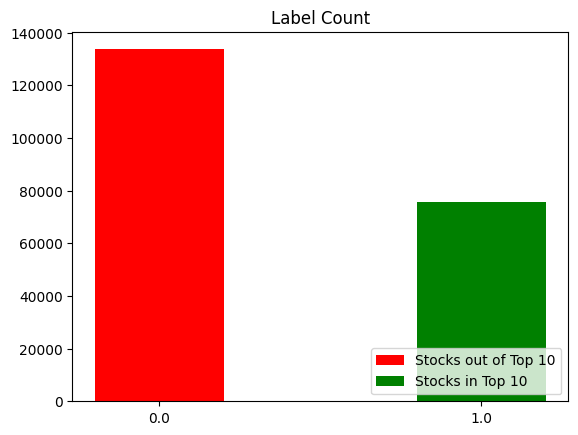

In [262]:
plt.bar(x_axis_labels, label_count, width=0.4, label=legend_label, color=['red','green'])
plt.title('Label Count')
plt.legend(loc='lower right');

In [263]:
dataset_2.value_counts(['ticker','label'])

ticker  label
TEF     0.0      4565
REP     0.0      4433
BBVA    0.0      4371
IBE     0.0      4297
SAN_1   0.0      4114
                 ... 
COL     1.0        36
ANE     1.0        34
RED     1.0        25
DRC     1.0        16
EBRO_1  1.0         8
Name: count, Length: 194, dtype: int64

In [264]:
stocks_labeled = dataset_2.value_counts(['ticker','label'])

fig, ax = plt.subplots(layout='constrained')

x = np.arange(97)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

for ticker, label in stocks_labeled.index:
    offset = width * multiplier
    rects = ax.bar(x + offset , ticker, width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001CE82A57E20> (for post_execute):


KeyboardInterrupt: 

In [265]:
dataset_2.sort_values('date', inplace=True)

In [266]:
train_val_dataset = dataset_2.loc[dataset['date'] < '2021-01-01']
dataset_test = dataset_2.loc[dataset['date'] >= '2021-01-01']
train_val_dataset.shape, dataset_test.shape

((186365, 25), (22998, 25))

In [267]:
val_split = math.floor(train_val_dataset.shape[0] * 0.8)
dataset_train = train_val_dataset.iloc[:val_split]
dataset_val = train_val_dataset.iloc[val_split:]

In [268]:
from sklearn.utils import shuffle
dataset_train = shuffle(dataset_train)
dataset_val = shuffle(dataset_val)
dataset_test = shuffle(dataset_test)

In [363]:
X_train = dataset_train.iloc[:,2:-1]
X_val = dataset_val.iloc[:,2:-1]
X_test = dataset_test.iloc[:,2:-1]
y_train = dataset_train.iloc[:,-1]
y_val = dataset_val.iloc[:,-1]
y_test = dataset_test.iloc[:,-1]

In [270]:
from sklearn.preprocessing import StandardScaler

In [271]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [272]:
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [273]:
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((149092, 22), (37273, 22), (22998, 22))

In [274]:
input = Input(shape=(X_train_scaled.shape[1],))
    
layer_1 = Dense(12, activation='relu', kernel_regularizer=L2(0.0001))(input)
dropout_1 = Dropout(0.1)(layer_1)
layer_2 = Dense(6, activation='relu', kernel_regularizer=L2(0.0001))(dropout_1)
dropout_2 = Dropout(0.1)(layer_2)
layer_3 = Dense(3, activation='relu', kernel_regularizer=L2(0.0001))(dropout_2)
dropout_3 = Dropout(0.1)(layer_3)
flatten = Flatten()(dropout_3)

output = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=input, outputs=output)

model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense_28 (Dense)            (None, 12)                276       
                                                                 
 dropout_21 (Dropout)        (None, 12)                0         
                                                                 
 dense_29 (Dense)            (None, 6)                 78        
                                                                 
 dropout_22 (Dropout)        (None, 6)                 0         
                                                                 
 dense_30 (Dense)            (None, 3)                 21        
                                                                 
 dropout_23 (Dropout)        (None, 3)                 0   

In [145]:
from sklearn.inspection import permutation_importance
perm = permutation_importance(model, X_test_scaled, y_test.astype(int), scoring='neg_mean_squared_error', n_repeats=10, random_state=42, n_jobs=2)

719/719 [==============================] - 1s 1ms/step


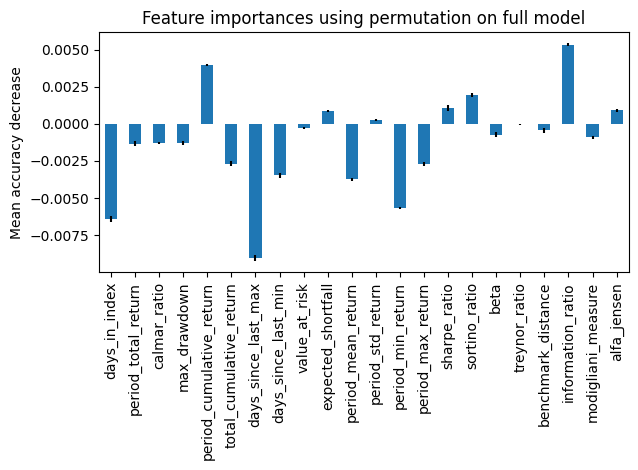

In [146]:
feature_importances = pd.Series(perm.importances_mean, index=dataset_2.columns[2:-1])

fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=perm.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [40]:
selected_features = feature_importances[feature_importances > 0.05]
selected_features

Series([], dtype: float64)

In [800]:
X_train_selected = X_train[selected_features.index]
X_val_selected = X_val[selected_features.index]
X_test_selected = X_test[selected_features.index]

In [801]:
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
X_val_scaled_selected = scaler.transform(X_val_selected)
X_test_scaled_selected = scaler.transform(X_test_selected)

ValueError: at least one array or dtype is required

In [275]:
input = Input(shape=(X_train_scaled.shape[1],))
    
layer_1 = Dense(12, activation='relu', kernel_regularizer=L2(0.0001))(input)
dropout_1 = Dropout(0.1)(layer_1)
layer_2 = Dense(6, activation='relu', kernel_regularizer=L2(0.0001))(dropout_1)
dropout_2 = Dropout(0.1)(layer_2)
layer_3 = Dense(3, activation='relu', kernel_regularizer=L2(0.0001))(dropout_2)
dropout_3 = Dropout(0.1)(layer_3)
flatten = Flatten()(dropout_3)

output = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=input, outputs=output)

model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense_32 (Dense)            (None, 12)                276       
                                                                 
 dropout_24 (Dropout)        (None, 12)                0         
                                                                 
 dense_33 (Dense)            (None, 6)                 78        
                                                                 
 dropout_25 (Dropout)        (None, 6)                 0         
                                                                 
 dense_34 (Dense)            (None, 3)                 21        
                                                                 
 dropout_26 (Dropout)        (None, 3)                 0   

In [276]:
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    # mode='min',
    restore_best_weights=True
    )

In [277]:
batch_size = 32
h = model.fit(
    # X_train_scaled_selected, y_train,
    X_train_scaled, y_train,
      epochs=100,
      batch_size = batch_size,
      # validation_data = (X_val_scaled_selected, y_val),
      validation_data = (X_val_scaled, y_val),
      callbacks = [earlystopping],
      shuffle=True,
      verbose=True
          )


Epoch 1/100
4660/4660 [==============================] - 13s 3ms/step - loss: 0.6073 - accuracy: 0.7396 - val_loss: 0.4913 - val_accuracy: 0.9023
Epoch 2/100
4660/4660 [==============================] - 11s 2ms/step - loss: 0.4704 - accuracy: 0.8507 - val_loss: 0.3894 - val_accuracy: 0.9175
Epoch 3/100
4660/4660 [==============================] - 11s 2ms/step - loss: 0.4119 - accuracy: 0.8593 - val_loss: 0.3259 - val_accuracy: 0.9226
Epoch 4/100
4660/4660 [==============================] - 12s 3ms/step - loss: 0.3776 - accuracy: 0.8625 - val_loss: 0.2864 - val_accuracy: 0.9239
Epoch 5/100
4660/4660 [==============================] - 12s 3ms/step - loss: 0.3556 - accuracy: 0.8635 - val_loss: 0.2594 - val_accuracy: 0.9262
Epoch 6/100
4660/4660 [==============================] - 11s 2ms/step - loss: 0.3440 - accuracy: 0.8646 - val_loss: 0.2433 - val_accuracy: 0.9266
Epoch 7/100
4660/4660 [==============================] - 11s 2ms/step - loss: 0.3347 - accuracy: 0.8660 - val_loss: 0.2320 -

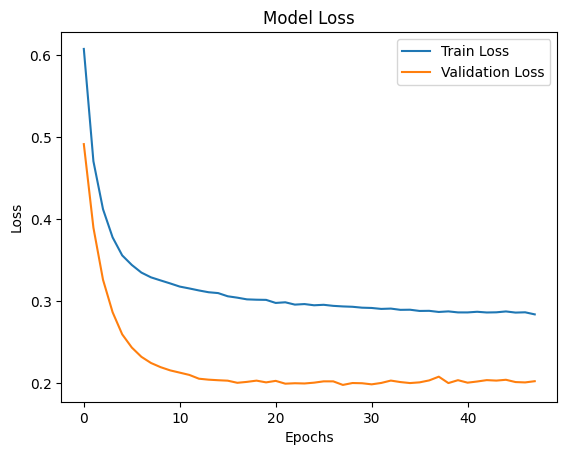

In [278]:
plt.plot(h.history['loss'],label='Train Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

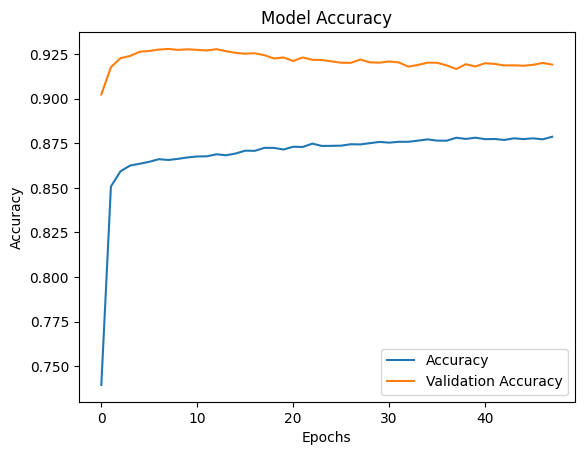

In [279]:
plt.plot(h.history['accuracy'],label='Accuracy')
plt.plot(h.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [364]:
y_pred_probas = model.predict(X_test_scaled)
y_pred = y_pred_probas.copy()

719/719 [==============================] - 1s 2ms/step


In [365]:
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.

In [366]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix, precision_score,recall_score, precision_recall_curve,roc_curve

In [367]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [368]:
model.evaluate(X_test_scaled, y_test)

719/719 [==============================] - 1s 2ms/step - loss: 0.2337 - accuracy: 0.9064


[0.23367279767990112, 0.9063831567764282]

In [369]:
auc = roc_auc_score(y_test, y_pred_probas)
kappa = cohen_kappa_score(y_test, y_pred)
confusion_matrix(y_test, y_pred,normalize='all')

array([[0.64175146, 0.06735368],
       [0.02626315, 0.26463171]])

In [370]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_probas)

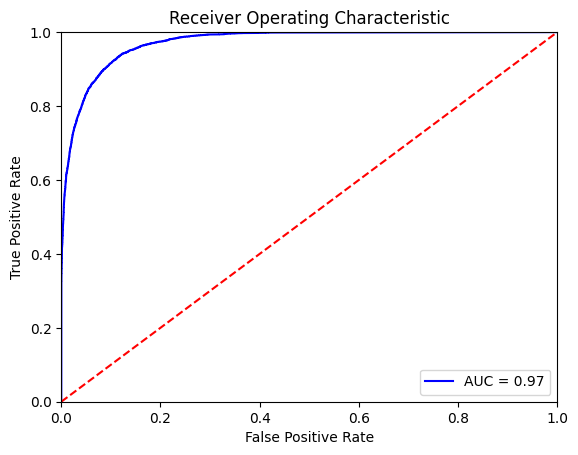

In [371]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


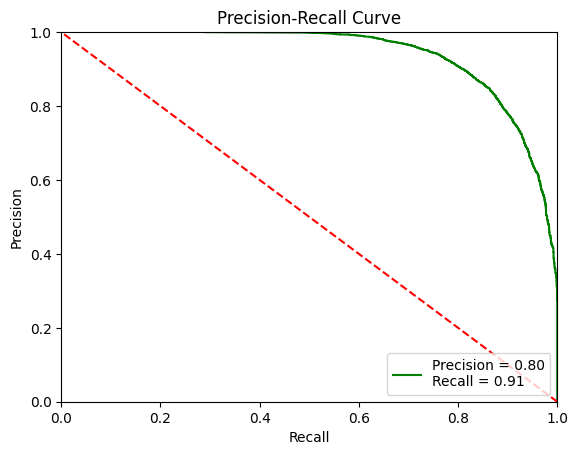

In [372]:
precision, recall,thres = precision_recall_curve(y_test, y_pred_probas)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
plt.title('Precision-Recall Curve')
plt.plot(precision, recall, 'g', label = 'Precision = %0.2f\nRecall = %0.2f' % (prec, rec))
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall');

In [373]:
y_pred = pd.DataFrame(y_pred)
y_test = y_test.reset_index()

In [374]:
predictions = pd.concat([y_test, y_pred], axis=1)
predictions.head()

,index,label,0
0,132632,0.0,0.0
1,132526,0.0,0.0
2,134165,0.0,0.0
3,54189,1.0,1.0
4,102171,0.0,0.0


In [375]:
predictions = predictions.rename(columns={0:'y_pred', 'label':'y_test'})

In [376]:
predictions['y_pred'] = predictions['y_pred'].astype('int')
predictions['y_test'] = predictions['y_test'].astype('int')

In [377]:
indexes = predictions.loc[predictions['y_pred']==1]['index'].values

In [378]:
predictions

,index,y_test,y_pred
0,132632,0,0
1,132526,0,0
2,134165,0,0
3,54189,1,1
4,102171,0,0
...,...,...,...
22993,208682,0,0
22994,136016,1,1
22995,140078,0,1
22996,195795,1,1


In [404]:
dataset_2.loc[indexes].sort_values('date').loc[dataset_2['date']=='2023-06-20']

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,days_since_last_max,days_since_last_min,...,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen,label
184415,SCYR_2,2023-06-20,257,0.029034,0.155196,-0.336317,0.024150,0.211151,113,270,...,0.041431,-3.596678,-0.964608,1.555054,0.000518,0.010950,-0.010204,0.029962,-0.133184,0.0
174011,SAB,2023-06-20,4841,0.028002,0.053154,-0.938345,0.093701,-0.602890,5964,964,...,0.041549,-3.029730,-0.951170,1.882137,0.001659,0.012538,0.175624,0.033594,-0.147901,1.0
155808,RED,2023-06-20,262,0.001482,0.200386,-0.259101,0.032389,-0.061160,302,250,...,0.046144,-4.440713,-0.976356,0.366461,0.002946,0.011948,0.013250,0.024556,-0.071006,0.0
134676,MEL,2023-06-20,1757,-0.014341,0.062715,-0.794856,0.094519,-0.526880,2209,1189,...,0.038449,-2.776590,-0.942647,0.587643,0.005361,0.017596,0.125733,0.035215,-0.080455,1.0
180909,SAN_1,2023-06-20,5505,0.016555,0.069008,-0.766811,0.002509,0.040587,4908,1000,...,0.030202,-4.233630,-0.974078,1.598719,0.000052,0.008035,-0.102729,0.025882,-0.136180,0.0
30662,AMS_1,2023-06-20,3189,-0.020779,0.057383,-0.874647,0.084311,1.660541,1723,4277,...,0.020125,-5.126579,-0.982102,0.601489,0.004672,0.009390,0.202215,0.020162,-0.081516,1.0
75676,ELE_1,2023-06-20,2172,0.008425,0.078341,-0.652303,0.056936,0.881036,942,3088,...,0.024415,-5.386099,-0.983744,0.938752,0.002022,0.007292,0.133237,0.018500,-0.099994,1.0
124628,ITX,2023-06-20,5591,0.013686,0.053919,-0.932375,0.081828,2.442309,2209,7942,...,0.055324,-3.688981,-0.966302,1.070677,0.002548,0.011727,0.153496,0.029371,-0.106035,1.0
88117,FDR,2023-06-20,571,-0.052180,0.076356,-0.676316,0.040772,-0.341655,635,242,...,0.039579,-3.226278,-0.956568,0.857257,0.001585,0.014816,0.029240,0.032335,-0.096288,0.0
60867,CABK,2023-06-20,3062,0.021668,0.076752,-0.646003,0.102545,0.134457,106,4037,...,0.034417,-3.779301,-0.967787,1.535573,0.002226,0.009512,0.267761,0.028792,-0.129557,1.0


In [76]:
dataset_results = dataset.iloc[predictions['index']].sort_index()
dataset_results

,ticker,date,days_in_index,period_total_return,calmar_ratio,max_drawdown,period_cumulative_return,total_cumulative_return,period_mean_return,period_std_return,...,period_max_return,sharpe_ratio,sortino_ratio,beta,treynor_ratio,benchmark_distance,information_ratio,modigliani_measure,alfa_jensen,label
12507,ACS,2021-01-04,5772,0.018905,-0.001122,-0.925131,0.056353,1.596892,0.001878,0.019079,...,0.051768,0.054429,0.096996,0.940494,0.001997,0.015735,0.073656,0.001446,0.000909,1.0
12508,ACS,2021-01-05,5773,-0.012737,-0.001750,-0.925131,0.075258,1.613051,0.002509,0.019232,...,0.051768,0.084160,0.151020,0.949047,0.002643,0.015963,0.126516,0.001824,0.001221,1.0
12509,ACS,2021-01-06,5774,-0.062881,-0.001323,-0.925131,0.062520,1.634673,0.002084,0.018636,...,0.051768,0.065679,0.114409,0.888067,0.002347,0.014820,0.038311,0.001678,0.001799,0.0
12510,ACS,2021-01-07,5775,-0.002153,0.000943,-0.925131,-0.000360,1.623560,-0.000012,0.016237,...,0.032875,-0.053704,-0.079857,0.723101,-0.000017,0.013931,-0.070089,0.000217,-0.000786,0.0
12511,ACS,2021-01-08,5776,0.040186,0.001020,-0.925131,-0.002514,1.626080,-0.000084,0.016221,...,0.032875,-0.058185,-0.086431,0.722240,-0.000116,0.013926,-0.075156,0.000164,-0.000859,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208887,VIS_3,2021-12-13,1403,0.020376,0.007915,-0.397681,-0.077028,0.201305,-0.002568,0.011483,...,0.028889,-0.274112,-0.319256,0.254075,-0.010106,0.014612,0.047818,-0.003097,-0.004128,0.0
208888,VIS_3,2021-12-14,1404,0.018879,0.006031,-0.397681,-0.056652,0.200394,-0.001888,0.010927,...,0.028889,-0.219500,-0.267114,0.233937,-0.008072,0.014488,0.060236,-0.002453,-0.003167,0.0
208889,VIS_3,2021-12-15,1405,-0.022642,0.004323,-0.397681,-0.037773,0.217550,-0.001259,0.011467,...,0.028889,-0.149920,-0.192259,0.197463,-0.006376,0.015416,0.106116,-0.001576,-0.002385,0.0
208890,VIS_3,2021-12-16,1406,-0.051304,0.006346,-0.397681,-0.060415,0.223798,-0.002014,0.010075,...,0.017156,-0.250511,-0.281374,0.191185,-0.010533,0.014595,0.034445,-0.002961,-0.003104,0.0


In [78]:
portfolios = dataset.iloc[dataset.iloc[predictions['index']].index].sort_index()[['ticker', 'date', 'label']]
portfolios.set_index('date', inplace=True, drop=True)
portfolios

,ticker,label
date,,
2021-01-04,ACS,1.0
2021-01-05,ACS,1.0
2021-01-06,ACS,0.0
2021-01-07,ACS,0.0
2021-01-08,ACS,0.0
...,...,...
2021-12-13,VIS_3,0.0
2021-12-14,VIS_3,0.0
2021-12-15,VIS_3,0.0


In [73]:
portfolios = pd.get_dummies(portfolios, dtype=int).groupby('date').sum()